# VGG-16 Fine-tuning

In [2]:
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

In [3]:
hyperparams = {
    "transform" : transforms.Compose([ # 이미지 transform해주는 여러가지를 한꺼번에 가능
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.48235, 0.45882, 0.40784],
            std=[1.0/225.0, 1.0/225.0, 1.0/225.0]
        )
    ]),
    "batch_size" : 128,
    "learning_rate" : 1e-4,
    "epoch" : 3,
}
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=hyperparams['transform'])
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=hyperparams['transform'])

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_dataloader = DataLoader(
    train_dataset, batch_size=hyperparams['batch_size'], shuffle=True
)
test_dataloader = DataLoader(
    test_dataset, batch_size=hyperparams['batch_size'], shuffle=False
)

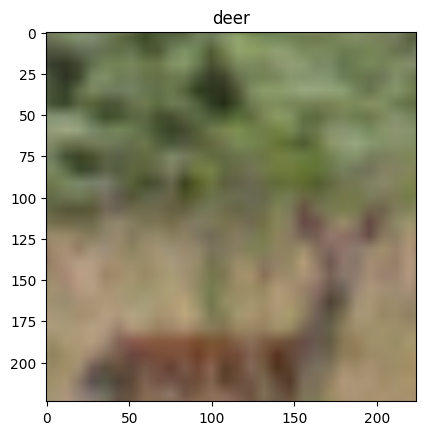

In [42]:
# DataLoader가 잘 불러와졌는지
import numpy as np
import matplotlib.pyplot as plt

mean=[0.48235, 0.45882, 0.40784]
std=[1.0/225.0, 1.0/225.0, 1.0/225.0]

images, labels = next(iter(train_dataloader))
for image, label in zip(images, labels):
  image = image.numpy().transpose((1,2,0)) # [C H W] to [H W C]
  image= ((std * image + mean) * 225).astype(np.uint8)

  plt.imshow(image)
  plt.title(train_dataset.classes[int(label)])
  plt.show()
  break

In [5]:
from torchvision import models
from torch import nn

In [30]:
model = models.vgg16(
    weights = "VGG16_Weights.IMAGENET1K_V1"
)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 97.1MB/s]


In [31]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [34]:
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [36]:
# 맨 마지막 Linear에서 out_features는 몇개로 분류할지에 대한 것. 1000개는 너무 많으니, 10개로 바꾸자!
model.classifier[6] = nn.Linear(4096, len(train_dataset.classes))

In [37]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
import torch
from torch import optim
from torch.nn import functional as F # convention
from tqdm import tqdm # 예쁘게 출력하기 위해

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model =  model.to(device)

criterion = nn.CrossEntropyLoss().to(device) # loss_fn
optimizer = optim.SGD(model.parameters(), lr=hyperparams['learning_rate'])

# 학습
for epoch in range(hyperparams['epoch']):
  loss = 0
  for images, classes in tqdm(train_dataloader): # tqdm 시각화
    images, classes = images.to(device), classes.to(device)

    output = model(images)
    cost = criterion(output, classes)

    optimizer.zero_grad() # 비워줌
    cost.backward() # loss graph 만들어줌
    optimizer.step()

    loss += cost
  loss /= len(train_dataloader)
  print(f"Epoch : {epoch+1}, Loss : {loss: .4f}")

  0%|          | 0/391 [00:00<?, ?it/s]

torch.Size([128, 64, 56, 56])


AttributeError: 'NoneType' object has no attribute 'shape'

In [50]:
from torch.utils.data import Subset

subset_indices = list(range(5000)) # data 5000개만
train_subset = Subset(train_dataset, subset_indices)
train_dataloader = DataLoader(
    train_subset, batch_size=hyperparams['batch_size'], shuffle=True
)
len(train_subset)

5000

# ResNet - Basic Block

In [12]:
class BasicBlock(nn.Module):
  def __init__(self, in_channel, out_channel, stride=1 ): #우리가 건들 수 있는 거는 channel 수
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                           kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channel)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                           kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channel)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_channel != out_channel:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                    kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(out_channel)
      )

  def forward(self, x): # input 들어오면 보내주는 건듯
    print(x.shape)
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out += self.shortcut(x) # 원래는 x를 더해주는..건데 shortcut으로 convolution 할 수 있으니까(?)
    out = self.relu(out)
    return out

In [13]:
class ResNet(nn.Module) :
  def __init__(self, block, layers, num_classes=10):
    super().__init__()
    self.in_channels = 64
    self.stem = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=self.in_channels,
                kernel_size=7, stride=2, padding=3, bias=False), # in RGB라서 3
      nn.BatchNorm2d(self.in_channels),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )
    self.stage1 = self._make_layers(block, 64, layers[0], stride=1)
    self.stage2 = self._make_layers(block, 128, layers[1], stride=2)
    self.stage3 = self._make_layers(block, 256, layers[2], stride=2)
    self.stage4 = self._make_layers(block, 512, layers[3], stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512, num_classes)

  def _make_layers(self, block, out_channels, num_block, stride):
    layers = []
    layers.append(block(self.in_channels, out_channels, stride))
    self.in_channels = out_channels
    for _ in range(num_block-1):
      layers.append(block(self.in_channels, out_channels, 1))
    return nn.Sequential(*layers) # layers 안에 있는 요소들로 sequential 만들어줌

  def forward(self, x):
    out = self.stem(x)
    out = self.stage1(out)
    out = self.stage2(out)
    out = self.stage3(out)
    out = self.stage4(out)
    out = self.avgpool(out)
    out = torch.flatten(out, 1)
    out = self.fc(out)
    return out

In [14]:
model = ResNet(BasicBlock, [2,2,2,2], 10) # 표 참고
resnet34 = ResNet(BasicBlock, [3,4,6,3], 1000) # 비교

In [65]:
!pip install torchinfo

In [15]:
from torchinfo import summary
torch_model = models.resnet34(weights="ResNet34_Weights.IMAGENET1K_V1")
resnet34_info = summary(resnet34, (1,3,224,224), verbose=0)
torch_model_info = summary(torch_model, (1,3,224,224), verbose=0)
print(torch_model_info.total_params)
print(resnet34_info.total_params)

torch.Size([1, 64, 56, 56])
torch.Size([1, 64, 56, 56])
torch.Size([1, 64, 56, 56])
torch.Size([1, 64, 56, 56])
torch.Size([1, 128, 28, 28])
torch.Size([1, 128, 28, 28])
torch.Size([1, 128, 28, 28])
torch.Size([1, 128, 28, 28])
torch.Size([1, 256, 14, 14])
torch.Size([1, 256, 14, 14])
torch.Size([1, 256, 14, 14])
torch.Size([1, 256, 14, 14])
torch.Size([1, 256, 14, 14])
torch.Size([1, 256, 14, 14])
torch.Size([1, 512, 7, 7])
torch.Size([1, 512, 7, 7])
21797672
21797672
